# Library imports

In [126]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from skimage import io
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.tensorboard import SummaryWriter
import time
#import torchvision.transforms.functional as TF

In [61]:
if torch.cuda.device_count()>1:
    device = torch.device('cuda:2')
elif torch.cuda.device_count()==1:
    device = torch.device('cuda')
else: 
    device = torch.device('cpu')
print(device)

cpu


D:\dprogramms\anaconda\envs\shreg\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [5]:
rl = pd.read_csv("D:/data/roots/train.csv")

,image,tot_root_length,n_laterals,depth
0,monocot-sim-30-10-25.rsml.jpg,2375.78270,124,164.93068
1,monocot-sim-348-4-18.rsml.jpg,10114.11100,496,189.99200
2,dicot-sim-407-1-21.rsml.jpg,8269.03400,475,189.90733
3,monocot-sim-427-10-15.rsml.jpg,9242.80500,516,204.97801
4,dicot-sim-6-10-25.rsml.jpg,403.78925,25,104.98667
...,...,...,...,...
8366,monocot-sim-300-2-16.rsml.jpg,6040.82280,438,164.93068
8367,dicot-sim-143-3-25.rsml.jpg,283.15573,10,224.95934
8368,dicot-sim-444-2-19.rsml.jpg,7077.47750,540,149.94467
8369,monocot-sim-59-5-25.rsml.jpg,317.75073,9,134.95866


In [39]:
tmean = np.zeros([4,3])
tmean[0,:] = rl.mean(numeric_only = True)
tmean[1,:] = rl.std(numeric_only = True)
tmean[2,:] = rl.min(numeric_only = True)
tmean[3,:] = rl.max(numeric_only = True)
#tmean[2,:] = rl.min(axis = 0)
#tmean[3,:] = rl.max(axis = 0)

# Dataset definition

In [44]:
class RootDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.rootlabels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.rootlabels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
#        img = np.zeros([3,1000,1800,1])
        #for i in range(3):
        img_name = \
        os.path.join(self.root_dir,\
                     self.rootlabels.iloc[idx, 0]).replace('\\','/')
        #img = np.expand_dims(np.asarray(io.imread(img_name)), axis=2)
        img = np.asarray(io.imread(img_name))
        landmarks = self.rootlabels.iloc[idx, 1:]
        landmarks = np.array([landmarks])
#        landmarks = landmarks.astype('float')
        landmarks = landmarks.astype('float').reshape(-1, 3)
        sample = {'image': img, 'landmarks': landmarks}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [ ]:


# a simple custom collate function, just to show the idea
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]
                      collate_fn=my_collate,


def show_image_batch(img_list, title=None):
    num = len(img_list)
    fig = plt.figure()
    for i in range(num):
        ax = fig.add_subplot(1, num, i+1)
        ax.imshow(img_list[i].numpy().transpose([1,2,0]))
        ax.set_title(title[i])

    plt.show()

#  do not do randomCrop to show that the custom collate_fn can handle images of different size
train_transforms = transforms.Compose([transforms.Scale(size = 224),
                                       transforms.ToTensor(),
                                       ])

# change root to valid dir in your system, see ImageFolder documentation for more info
train_dataset = datasets.ImageFolder(root="/hd1/jdhao/toyset",
                                     transform=train_transforms)

trainset = DataLoader(dataset=train_dataset,
                      batch_size=4,
                      shuffle=True,
                      collate_fn=my_collate, # use custom collate function here
                      pin_memory=True)

trainiter = iter(trainset)
imgs, labels = trainiter.next()

# print(type(imgs), type(labels))
show_image_batch(imgs, title=[train_dataset.classes[x] for x in labels])

0 (2521, 1833) (1, 3)
1 (2816, 908) (1, 3)
2 (2816, 1135) (1, 3)
3 (2993, 964) (1, 3)


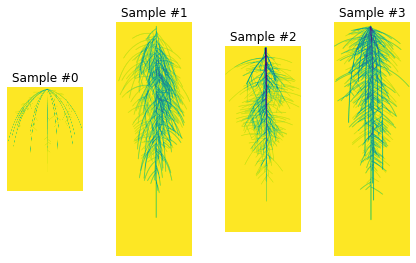

In [117]:
dataset = RootDataset(csv_file='D:/data/roots/train.csv',
                                    root_dir='D:/data/roots/images')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])
#    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [122]:
class Norm(object):
    def __init__(self, tmean):
#        assert isinstance(tmean, tuple)
        self.tmean = tmean
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        landmarks = (landmarks - self.tmean[0])/self.tmean[1]
        
        return {'image': image,
                'landmarks': landmarks}
class Minmax(object):
    def __init__(self, tmean):
#        assert isinstance(tmean, numpy.ndarray)
        self.tmean = tmean
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
#        print(type(landmarks))
#        print(type(self.tmean[3]))
        landmarks = (landmarks - self.tmean[2])/(self.tmean[3]-self.tmean[2])
        
        return {'image': image,
                'landmarks': landmarks}
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __init__(self, device):
#        assert isinstance(device, str)
        self.device = device
    def __call__(self, sample):
        #print(self.device)
        image, landmarks = sample['image'], sample['landmarks']

        landmarks = np.squeeze(landmarks)
        return {'image': torch.Tensor(image).to(self.device),
                'landmarks': torch.Tensor(landmarks).to(self.device)}
class CmsCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image[0].shape[0:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        h, w = image[0].shape[0:2]
        new_image = np.zeros([3,new_h, new_w])
        for i in range(3):
            img = np.squeeze(255-image[i])
            properties = regionprops((img > filters.threshold_otsu(img)).astype(int), img)
            cms = tuple(map(lambda x: int(x), properties[0].centroid))
#            print((cms[0]-new_h//2)-(cms[0]+new_h//2),(cms[1]-new_w//2)-(cms[1]+new_w//2))
#            print(new_image.shape)
            tempa = (255-img[cms[0]-new_h//2:cms[0]+new_h//2,\
                                  cms[1]-new_w//2:cms[1]+new_w//2]).astype(np.uint8)
            padh = (new_h-tempa.shape[0])//2
            padw = (new_w-tempa.shape[1])//2
            tempb = np.pad(tempa, \
                ((padh, new_h-tempa.shape[0]-padh),(padw,new_w-tempa.shape[1]-padw)),\
                mode='constant', constant_values = 255)
#            print(tempb.shape)
            new_image[i] = tempb
        return {'image': new_image/255, 'landmarks': landmarks}
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image[0].shape[0:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = np.zeros([3,new_h, new_w])
        for i in range(3):
            img[i] = transform.resize(image[i], (new_h, new_w))
        transforms.ToTensor()
        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
#        print('.', end='')
        return {'image': img, 'landmarks': landmarks}

# Neural network

In [86]:
def getsize(new_hi,ker,srd): 
    pad = (0,0)
    dil = np.asarray((1,1))
    return(tuple((np.squeeze((np.asarray(new_hi)+\
    2*np.asarray(pad)-dil*[np.asarray(ker)-1]+1)/\
                             np.asarray(srd))).astype(int)))
class MLP(nn.Module):
    def __init__(self,tupa) :
        super().__init__()
        epochs, bn, bs, lr, modelname, \
        crop_h, new_h, m_kernel, m_stride, \
        rep, hidden_dim, optim, testf, valf,\
        dataset, C_in\
        = tupa
        self.pool = nn.MaxPool2d(m_kernel,m_stride)
        idt = tuple(map(lambda x: x, \
                getsize((new_h, new_h),m_kernel,m_stride)))
        input_dim = idt[0]*idt[1]*C_in
        current_dim = input_dim
        self.layers = nn.ModuleList()
        for hdim in hidden_dim:
            self.layers.append(nn.Linear(current_dim, hdim))
            current_dim = hdim
        self.layers.append(nn.Linear(current_dim, 3))
        
    def forward(self, x):
        x = self.pool(x)
        x = x.view(x.shape[0],-1)
        for layer in self.layers[:-1]:
            x = F.leaky_relu(layer(x))
        out = F.softmax(self.layers[-1](x))
        return out  
nnarchitectures = {'MLP':MLP}

# Train algo

In [104]:
# def rbatch(sb, tups):
#     bs, new_h, ampl, C_in, ratio, randin = tups
#     if randin == 0:
#         return(sb['image'],sb['landmarks'])  
#     elif randin == 1:
#         return(torch.rand([bs, C_in, new_h, int(ratio*new_h)]).to(device), sb['landmarks'])
#     elif randin == 2:
#         return(sb['image'], torch.rand([bs, ampl]).to(device))
#     elif randin == 3:
#         return(torch.rand([bs, C_in, new_h, int(ratio*new_h)]).to(device), \
#                torch.rand([bs, ampl]).to(device))    
def train(tupa):
    epochs, bn, bs, lr, modelname, \
           crop_h, new_h, m_kernel, m_stride, \
           rep, hidden_dim, optim, testf, valf,\
    dataset, C_in\
    = tupa
    print(dataset)
    starta = time.time()
    dataloader = DataLoader(dataset, bs,
                            shuffle=False, num_workers=0)
    model = nnarchitectures[modelname](tupa)
    model.to(device)
    if optim == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), \
                    lr, betas=(0.9, 0.999),\
                    eps=1e-08, weight_decay=0, \
                    amsgrad=False)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
    criterion = nn.MSELoss(reduction='mean')
    tl, pt = [], 0
#    pt = 0
#    lossa = np.zeros([2, epochs*(bn-2)])
    lossa = np.zeros([2, epochs])
    load_time = np.zeros([bn,epochs])
#    print(bn-2)
    tsize = int(bn*testf)
    vsize = int(bn*(1-testf)*valf)
#    tups = (bs, new_h, ampl, C_in, ratio, randin)
#    print(tsize,vsize,len(dataset))
    for i_batch, sb in enumerate(dataloader):
#        print(tsize)
#        print(i_batch < tsize, i_batch,i_batch >= tsize and i_batch < tsize + vsize)
        if i_batch < tsize:
            [xtest, ytest] = sb['image'], sb['landmarks']
        elif i_batch >= tsize and i_batch < tsize + vsize:
#            print(i_batch)
#            return 1
            [xval, yval] = sb['image'],sb['landmarks'] 
        else:
            break
    for j in range(epra):
        start = time.time()
        for i_batch, sb in enumerate(dataloader):
            if i_batch < tsize+vsize:
                continue
            if i_batch == bn:
                break
            [xtrain, ytrain] = sb['image'], sb['landmarks']
#            print(load_time[i_batch][j])
#            print(xtrain.shape)
            lts = time.time()

            y_pred = model(xtrain)
            loss = criterion(y_pred, ytrain)
            writer.add_scalar("Loss/train,", loss.item(), j)
#           print(i_batch,loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            load_time[i_batch][j] = time.time()-lts

#            i_los = j*(bn-2)+i_batch-2
            i_los = j
#            print(lossa.shape, ilos)
#            print(lossa.shape)
            lossa[0][i_los] += loss.item()
            lossa[1][i_los] += criterion(model(xval), yval).item()
            writer.add_scalar("Loss/validation,randin="+str(randin)+"dtp="+str(dtp), loss.item(), j)
        end = time.time()
        tl.append(end-start)
        col = coco(tl,epra,pt)
        pt = col[0]
        print(col[1], end = col[2])
    enda = time.time()
    timelapse = enda - starta
    writer.flush()
    print('',end='\n')
    lossa[1] *= (bn-vsize-tsize)/vsize
    return(model,lossa,timelapse,load_time)

# Hyperparameters

In [105]:
def runtrain(new_h=64, bs=1): 
    pam = gpam(new_h, bs)
    epochs, bn = pam[0], pam[1]
    timel, timelapse = [0]*2
    lossb = np.zeros([2, epochs])
    loadt = np.zeros([bn,epochs])
    writer = SummaryWriter()
#    for randin in range(2):
#    print(randin, i, randin+i*2)
    _, lossb, timelapse, load_time = train(pam)
    timel += timelapse
    writer.close()
    return(lossb, timel, load_time)

In [106]:
new_h = 60
bs = 1
lossb, timel, loadt = runtrain(new_h, bs)
traplot(timel)

ValueError: not enough values to unpack (expected 2, got 1)

# Try to load and transform the data

In [133]:
a = [x[1] for x in [[0,1,2,3],[0,1,2,3]]]
print(a)

[1, 1]


In [127]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]

In [130]:
# transformed_dataset = RootDataset(csv_file='data/faces/face_landmarks.csv',
#                                            root_dir='data/faces/',
#                                            transform=transforms.Compose([
#                                                Rescale(256),
#                                                RandomCrop(224),
#                                                ToTensor()
#                                            ]))
# composed = transforms.Compose([CmsCrop(550),Rescale(new_h),\
#                            Minmax(tmean),\
#                             ToTensor(device)])
#print(device)
composed = transforms.Compose([Minmax(tmean),ToTensor(device)])
dataset = RootDataset(csv_file='D:/data/roots/train.csv',
                            root_dir='D:/data/roots/images',
                      transform=composed)

dataloader = DataLoader(dataset, batch_size=1,
                        shuffle=False, num_workers=0, collate_fn=my_collate)

# print(dataloader)
# for i_batch, sample_batched in enumerate(dataloader):
#     print(i_batch)
    
for i in range(len(dataset)):
    sample = dataset[i]
    print(i, sample['image'].size(), sample['landmarks'].size()  )

    if i == 3:
        break
#    print(i_batch, sample_batched['image'].size(),sample_batched['landmarks'].size())
    
# for i in range(len(dataset)):
#     sample = dataset[i]

#     print(i, sample['image'].size(), sample['landmarks'].size())

#     if i == 3:
#         break

0 torch.Size([2521, 1833]) torch.Size([3])
1 torch.Size([2816, 908]) torch.Size([3])
2 torch.Size([2816, 1135]) torch.Size([3])
3 torch.Size([2993, 964]) torch.Size([3])


In [100]:
def gpam(new_h = 64, bs = 1, randin = 0):
    epochs = 5 #how many epochs 
    bn = 5 #how many batches
    lr = 5e-5 #learning rate
    modelname = 'MLP'
    crop_h = 550
    m_kernel = 2
    m_stride = 2
    rep = '(np.repeat(1024, 10),512)'
    hidar = {rep : (np.repeat(1024, 10),512)}
    hidden_dim = np.hstack(hidar[rep])
    optim = 'adam'
    testf = 0
    valf = 1/(4-(testf+1)/(testf-1))
    composed = transforms.Compose([CmsCrop(crop_h),Rescale(new_h),\
                               Minmax(tmean),\
                                ToTensor(device)])
    dataset = RootDataset(csv_file='D:/data/roots/train.csv',
                                root_dir='D:/data/roots/images',
                          transform=composed)
    C_in = 1
    return(epochs, bn, bs, lr, modelname, \
           crop_h, new_h, m_kernel, m_stride, \
           rep, hidden_dim, optim, testf, valf, dataset, C_in)

# Graphics plotting

In [55]:
def traplot(timel):
#     tupa = gpam+pam()
#     epochs, bn, bs, lr, modelname, \
#            crop_h, new_h, ampl, m_kernel, m_stride, \
#            rep, hidden_dim, optim, testf, valf = gpam()
    tupa = gpam()
    #     0 epochs, 1 bn, 2 bs, 3 lr, 4 modelname, \
#            5 crop_h, 6 new_h, 7 ampl, 8 m_kernel, 9 m_stride, \
#            10 rep, 11 hidden_dim, 12 optim, 13 testf, 14 valf,\
#     15 dataset, 16 C_in, 17 ratio, 18 ft, 19 n, 20 ovl, 21 gs, 22 randin = tupa
# 0, 1, 2, 3, 6, 10, 12
    epochs, bn, bs, lr, new_h, rep, optim = \
    tuple(tupa[i] for i in list(range(0, 4))+[6,10,12])        
    plt.rcParams["figure.figsize"] = (18,10)
    linestyles = ['-', '--', '-.', ':', '-', '--',\
                  '-.', ':', '-', '--', '-.', ':']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
    fig = plt.figure()
    axes = plt.gca()
#    labels_text = [['t', 'v'], ['t rand input', 'v rand input'], \
#                   ['t rand output', 'v rand output'], ['t rand both', 'v rand both'],]
    #labels_text = [['t', 'v'], ['$\widetilde{t}$', '$\widetilde{v}$']]*2 
    labels_text = [['t SH', 'v SH'], \
                   ['$\widetilde{t}$ SH', '$\widetilde{v}$ SH'], 
                  ['t el', 'v el'], \
                   ['$\widetilde{t}$ el', '$\widetilde{v}$ el']]
#     for i in range(len(labels_text)):
#         for j in range(len(labels_text[i])):
#             labels_text[i][j] += ' SH' if i < 2 else ' el'
    for trt in range(lossb.shape[1]):
        for isr in range(lossb.shape[0]):
#            cura = np.asarray(lossb[isr,trt])
            plt.plot(np.arange(lossb.shape[2]), \
                     lossb[isr,trt], label=labels_text[isr][trt], \
                     color = colors[isr], linestyle=linestyles[trt], \
                     linewidth=3)
    axes.set_xticks(np.arange(0, int(lossb[0][0].shape[0]*1.1),\
                              max(int(lossb[0][0].shape[0]*0.1),1)))
    #axes.set_yticks(np.arange(ymin, ymax, 1))
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='best', borderaxespad=0., \
               fontsize = 24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.autoscale(enable=True, axis='both', tight=None)
#     ymin, ymax = 0, 2
#     axes.set_ylim([ymin,ymax])
    plt.xlabel('Epoch', fontsize=24)
    plt.ylabel('MSE Loss', fontsize=24)
    plt.savefig('plot output/'+\
                'size='+str(new_h)+\
                'bn'+str(bn)+\
                'bs'+str(bs)+\
                'epochs'+str(epochs)+\
                'layers'+rep+\
                'lr'+str(lr)+\
                'optimizer'+str(optim)+\
                'etime'+format(timel,".2f")+\
                '.png', bbox_inches='tight')
    plt.title('Learning curve \n', fontsize=24)
    fig.text(.5, -.1, 't - training, v - validation, '\
    'SH - spherical harmonics, \n el - synthetic ellipses, '\
                       '$\widetilde{x}$ - random numbers on input',\
             ha='right',fontsize=24)
    plt.show()